# Make a Gardner-Altman Plot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get seaborn's fMRI dataset but remove the time variable & group it
df = sns.load_dataset('fmri')
df['subject'] = df['subject'].str.extract('(\d+)').astype(int)
df = df.sort_values(by='subject').reset_index(drop=True)
df = df.groupby(['subject', 'event', 'region'], as_index=False)['signal'].mean()
df.head(16)

,subject,event,region,signal
0,0,cue,frontal,0.013769
1,0,cue,parietal,0.006717
2,0,stim,frontal,-0.006226
3,0,stim,parietal,0.001046
4,1,cue,frontal,-0.008762
5,1,cue,parietal,-0.015268
6,1,stim,frontal,0.020972
7,1,stim,parietal,0.042970
8,2,cue,frontal,-0.001531
9,2,cue,parietal,0.003215


In [3]:
def chopplot(plot_type, data, x=None, y=None, side=-1, ax=None, **kwargs):
    # Takes a plotting function from seaborn that supports a 'hue' argument.
    
    data_ = ghost_hue(data=data)
    
    if x is None:
        # This seems required for the grouped split to show in the plot.
        x = 'X'
        data_[x] = 'i'
    
    # Determine which side to make viewable and which to ghost
    if side == -1:
        viewhue, ghosthue = 'A', 'B'
    else:
        viewhue, ghosthue = 'B', 'A'
    
    # Ghost it by making all its values nan
    data_.loc[data_['_hue'] == ghosthue, y] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    if plot_type == 'violin':
        plot_func = sns.violinplot
        kwargs['split'] = kwargs.get('split', True)
        kwargs['inner'] = kwargs.get('inner', None)
    elif plot_type == 'strip':
        plot_func = sns.stripplot
        kwargs['dodge'] = kwargs.get('dodge', True)
    elif plot_type == 'swarm':
        plot_func = sns.swarmplot
        # Useful for shifting swarmplot: https://stackoverflow.com/questions/56654941/how-to-change-the-position-of-a-single-swarm-group
    elif plot_type == 'box':
        plot_func = sns.boxplot
    elif plot_type == 'bar':
        plot_func = sns.barplot
    
    plot_func(data=data_, x=x, y=y, hue='_hue', **kwargs, ax=ax)

    ax.get_legend().remove()
    return ax

# Take a dataframe and duplicate it to create the ghost hue
def ghost_hue(data):
    A = data.copy()
    A['_hue'] = 'A'
    B = A.copy()
    B['_hue'] = 'B'
    return pd.concat([A, B])

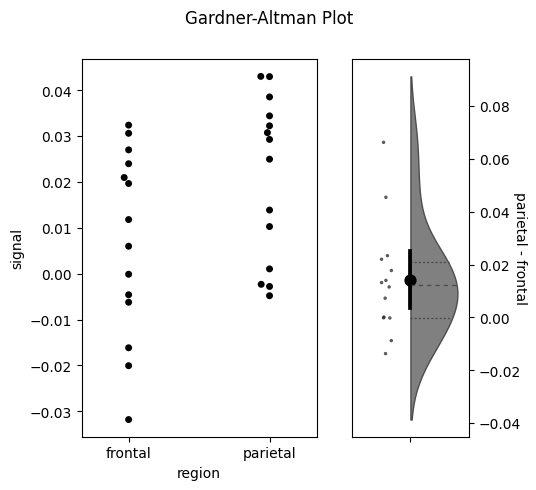

In [8]:
data = df.loc[df['event']=='stim'].drop('event', axis=1)

subject = 'subject'
factor = 'region'
y = 'signal'
a, b = 'frontal', 'parietal'
paired = False


# Get the difference
wide = data.set_index([subject, factor]).unstack(1)
wide.columns = [j for i, j in wide.columns]
diffname = f'{b}_minus_{a}'
wide[diffname] = wide[b] - wide[a]

fig, ax = plt.subplots(1, 2, figsize=(5,5), dpi=100, gridspec_kw={'width_ratios': [2,1]})

if paired:
    # Paired plot
    sns.lineplot(data=data, x=factor, y=y, units=subject, color='k', estimator=None, marker='o', markeredgecolor=None, ax=ax[0])
else:
    sns.swarmplot(data=data, x=factor, y=y, color='k', ax=ax[0])

# Difference plotting
chopplot(plot_type='violin', data=wide, y=diffname, color='grey', linewidth=1, alpha=0.5, side=1, inner='quartile', ax=ax[1])
chopplot(plot_type='strip', data=wide, y=diffname, linewidth=0, alpha=0.75, side=-1, color='k', marker='.', ax=ax[1], zorder=999)
sns.pointplot(data=wide, y=diffname, color='k', zorder=999, ax=ax[1], ci=95)

# Formatting
ax[0].set(xlim=(-1/3, 1+(1/3)))
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[1].set_ylabel(ax[1].get_ylabel().replace('_', ' ').replace('minus', '-'), rotation=-90)
ax[1].set(xlabel=None)
plt.suptitle('Gardner-Altman Plot')
plt.show()